# 라이브러리 불러오기

In [1]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import seaborn as sns
import folium
import datetime
import math

# 랜덤 시드 설정

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [3]:
_train_data = pd.read_csv('../../data/data/train.csv')
_test_data = pd.read_csv('../../data/data/test.csv')
sample_submission = pd.read_csv('../../data/data/sample_submission.csv')
subway_info = pd.read_csv('../../data/data/subwayInfo.csv')
school_info = pd.read_csv('../../data/data/schoolInfo.csv')
park_info = pd.read_csv('../../data/data/parkInfo.csv')
interest_rate = pd.read_csv('../../data/data/interestRate.csv')
_train_dist_data = pd.read_csv('../../data/data/train_dist.csv')
_test_dist_data = pd.read_csv('../../data/data/test_dist.csv')

# 데이터 전처리하기

In [7]:
# Train
# 날짜순으로 정렬
train_data = _train_dist_data.copy()
train_data["contract_year_month_day"] = pd.to_datetime(train_data["contract_year_month"] * 100 + train_data["contract_day"], format='%Y%m%d')
train_data = train_data.sort_values(by="contract_year_month_day")
# train_data.drop(columns=["contract_year_month", "contract_day"], inplace=True)

# 음수 age를 양수로 변환
train_data["age"] = train_data["age"].abs()

# duplicated data 제거
dup_df = train_data[train_data.drop(columns="index").duplicated()]
train_data = train_data.drop(index=dup_df.index)

train_data.shape

(1717611, 19)

In [5]:
# Test
test_data = _test_dist_data.copy()

# 음수 age를 양수로 변환
test_data["age"] = test_data["age"].abs()

# 데이터 EDA 수행하기

In [8]:
print("train, test_data, sample_submission shape : ", train_data.shape, test_data.shape, sample_submission.shape)
# print("train data 상단 5개 정보 확인 : ", train_data.head())
# print("test data 상단 5개 정보 확인 : ", test_data.head())
print("sample_submission 상단 5개 정보 확인 : ", sample_submission.describe())
print("train data 변수 요약 정보 확인 : \n", train_data.describe())
print("train_dist_data 변수 요약 정보 확인 : \n", _train_dist_data.describe())
print("test data 변수 요약 정보 확인 : \n", test_data.describe())
print("subway_info 변수 요약 정보 확인 : \n", subway_info.describe())
print("school_info 변수 요약 정보 확인 : \n", school_info.describe())
print("park_info 변수 요약 정보 확인 : \n", park_info.describe())
print("interest_rate 변수 요약 정보 확인 : \n", interest_rate.describe())

train, test_data, sample_submission shape :  (1717611, 19) (150172, 10) (150172, 2)
sample_submission 상단 5개 정보 확인 :                index   deposit
count  150172.00000  150172.0
mean    75085.50000       0.0
std     43351.06665       0.0
min         0.00000       0.0
25%     37542.75000       0.0
50%     75085.50000       0.0
75%    112628.25000       0.0
max    150171.00000       0.0
train data 변수 요약 정보 확인 : 
               index       area_m2  contract_year_month  contract_day  \
count  1.717611e+06  1.717611e+06         1.717611e+06  1.717611e+06   
mean   9.019509e+05  7.524180e+01         2.021336e+05  1.590339e+01   
min    0.000000e+00  1.032150e+01         2.019040e+05  1.000000e+00   
25%    4.534015e+05  5.975010e+01         2.020080e+05  9.000000e+00   
50%    9.022850e+05  7.792000e+01         2.021110e+05  1.600000e+01   
75%    1.351972e+06  8.496000e+01         2.022120e+05  2.300000e+01   
max    1.801227e+06  3.173600e+02         2.023120e+05  3.100000e+01   
std    5.1

# 클러스터링

In [92]:
kmeans = KMeans(n_clusters=100)
train_data['cluster_100'] = kmeans.fit_predict(train_data[['latitude', 'longitude']])

In [101]:
clusters = train_data[["cluster_100", "latitude", "longitude", "deposit"]].groupby("cluster_100").mean()

In [151]:
# 지도 생성 (초기 중심 좌표와 줌 레벨 설정)
m = folium.Map(location=[37.5665, 126.9780], zoom_start=12)  # 서울 좌표 예시

# norm으로 red의 채도 변화 후 hex값으로 저장
norm = (clusters["deposit"] - clusters["deposit"].min()) / (clusters["deposit"].max() - clusters["deposit"].min())
colors = [(mcolors.to_hex([1-c, 0.5-c/2, 1])) for c in norm]

# 지도에 마커 추가 (서울 위치에 마커 추가)
for index, (lat, lon, deposit) in enumerate(zip(clusters["latitude"], clusters["longitude"], clusters["deposit"])):
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,  # 원의 크기를 조정
        popup=deposit,
        color=colors[index],
        fill=True,
        fill_color=colors[index]
    ).add_to(m)
    
m

# 평당 가격 추가

In [ ]:
train_data['deposit_per_area'] = train_data['deposit'] / train_data['area_m2']

# 아파트별 거래 시점 이전의 가장 최근 거래가

In [119]:
def get_previous_value(group):
    group['prev_deposit_per_area'] = group['deposit_per_area'].shift()  # 바로 이전 value 가져오기
    return group

In [120]:
# 같은 lat과 long의 데이터들 중에서 가장 가까운 이전 날짜의 행을 찾아 병합
train_data = train_data.groupby(['latitude', 'longitude']).apply(get_previous_value).reset_index(drop=True)

C:\Users\LHY\AppData\Local\Temp\ipykernel_4228\3430458235.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_lag = train_data.groupby(['latitude', 'longitude']).apply(get_previous_value)


In [129]:
# 결측치는 -999로 채우기
train_data.fillna(-999, inplace=True)

(1717611, 22)

# 대회에 필요한 데이터만 활용하기

In [141]:
train_data.columns

Index(['index', 'area_m2', 'contract_year_month', 'contract_day',
       'contract_type', 'floor', 'built_year', 'latitude', 'longitude', 'age',
       'deposit', 'nearest_subway_distance', 'nearest_subway_id',
       'nearest_school_distance', 'nearest_school_id', 'nearest_park_distance',
       'nearest_park_id', 'interest_rate', 'contract_year_month_day',
       'deposit_per_area', 'cluster_100', 'prev_deposit_per_area'],
      dtype='object')

In [137]:
# 필요 없는 column 제거
train_df = train_data.drop(columns=["index", "contract_year_month_day"])

# contract_year_month, contract_day를 contract_year_month_day로 통합
train_df["contract_year_month_day"] = train_df["contract_year_month"] * 100 + train_df["contract_day"]
train_df.drop(columns=["contract_year_month", "contract_day"], inplace=True)

In [138]:
# cluster를 one-hot encoding
train_df = pd.get_dummies(train_df, columns=["cluster_100"])
train_df.head()

,area_m2,contract_type,floor,built_year,latitude,longitude,age,deposit,nearest_subway_distance,nearest_subway_id,...,cluster_100_90,cluster_100_91,cluster_100_92,cluster_100_93,cluster_100_94,cluster_100_95,cluster_100_96,cluster_100_97,cluster_100_98,cluster_100_99
0,59.79,2,14,1996,36.91791,126.908029,24,5000.0,16941.60989,21.0,...,False,False,False,False,False,False,False,False,False,False
1,78.05,2,9,1996,36.91791,126.908029,25,7000.0,16941.60989,21.0,...,False,False,False,False,False,False,False,False,False,False
2,78.05,0,10,1996,36.91791,126.908029,25,7000.0,16941.60989,21.0,...,False,False,False,False,False,False,False,False,False,False
3,78.05,0,6,1996,36.91791,126.908029,25,7000.0,16941.60989,21.0,...,False,False,False,False,False,False,False,False,False,False
4,59.79,2,3,1996,36.91791,126.908029,25,6000.0,16941.60989,21.0,...,False,False,False,False,False,False,False,False,False,False


(14767, 22)


<function matplotlib.pyplot.ylim(*args, **kwargs) -> 'tuple[float, float]'>

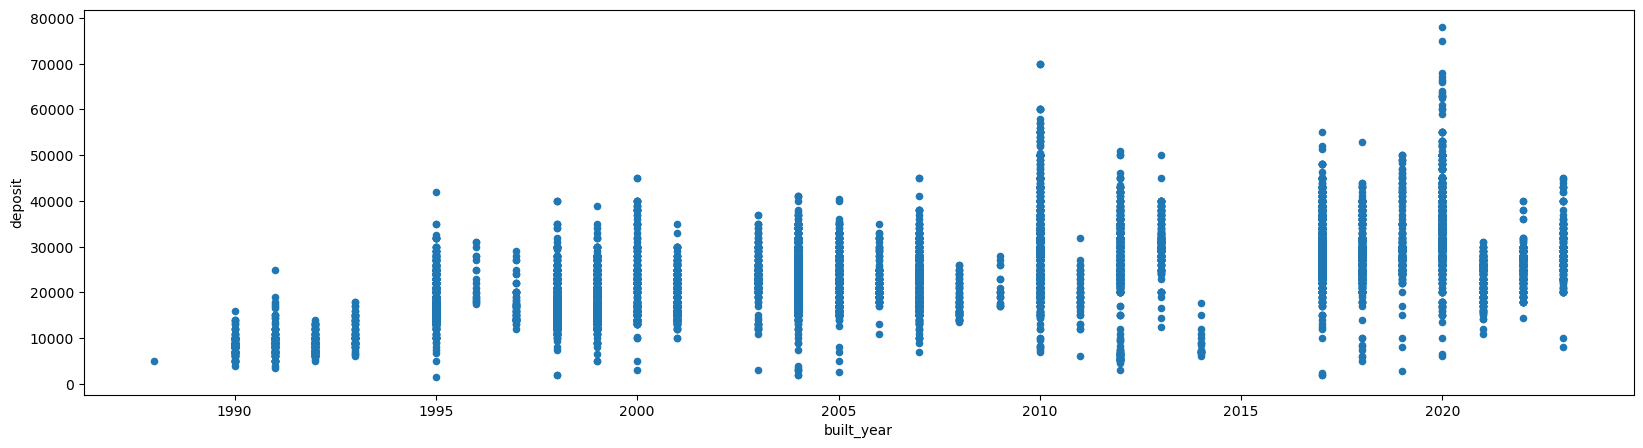

In [134]:
# 각 cluster별 built_year과의 상관관계 plot
cluster_idx=17
cluster_0 = train_data[train_data["cluster_100"] == cluster_idx].sort_values(by="built_year")
print(cluster_0.shape)
cluster_0.plot(x="built_year", y="deposit", figsize=(20, 5), kind="scatter")
plt.ylim

In [139]:
# contract_type을 one-hot encoding
train_df = pd.get_dummies(train_df, columns=["contract_type"])
train_df.shape

(1717611, 120)

# Holdout 데이터셋 설정 (예: 2023년 7월부터 12월까지의 데이터)

In [140]:
holdout_start = 20230701
holdout_end = 20231231
holdout_data = train_df[(train_df['contract_year_month_day'] >= holdout_start) & (train_df['contract_year_month_day'] <= holdout_end)]
train_df = train_df[~((train_df['contract_year_month_day'] >= holdout_start) & (train_df['contract_year_month_day'] <= holdout_end))]

# 학습 데이터와 정답 데이터 분리

In [142]:
# target을 deposit_per_area로 변경
X_train = train_df.drop(columns=['deposit', 'deposit_per_area'])
deposit_per_area_train = train_df['deposit_per_area']
y_train = train_df['deposit']

X_holdout = holdout_data.drop(columns=['deposit', 'deposit_per_area'])
deposit_per_area_holdout = holdout_data['deposit_per_area']
y_holdout = holdout_data['deposit']

# LightGBM 모델 훈련 with KFold

In [161]:
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
# lgb_model.fit(X_train, deposit_per_area_train)

# batch로 나눠서 학습
batch_num = 30
batch_size = len(X_train) // batch_num
for i in range(0, len(X_train), batch_size):
    X_batch = X_train[i:i+batch_size]
    y_batch = deposit_per_area_train[i:i+batch_size]
    # lgb_model.fit(X_batch, y_batch)
    lgb_model.fit(X_batch, y_batch, init_model=lgb_model if i != 0 else None)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2495
[LightGBM] [Info] Number of data points in the train set: 50632, number of used features: 28
[LightGBM] [Info] Start training from score 251.496599
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 50632, number of used features: 26
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [I

# Holdout 데이터셋에 대한 성능 확인

In [162]:
lgb_holdout_pred = lgb_model.predict(X_holdout)
deposit_holdout_pred = lgb_holdout_pred * X_holdout['area_m2']
lgb_holdout_mae = mean_absolute_error(y_holdout, deposit_holdout_pred)
print("Holdout 데이터셋 성능:")
print(f"LightGBM MAE: {lgb_holdout_mae:.2f}")

Holdout 데이터셋 성능:
LightGBM MAE: 28539.00


Text(0.5, 1.0, 'Feature importance')

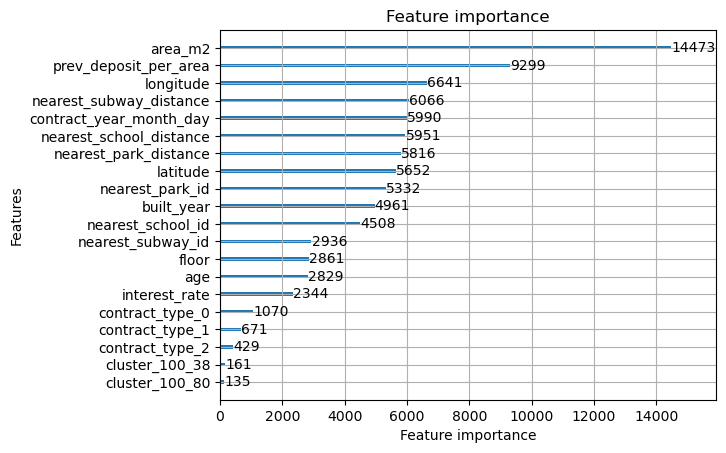

In [163]:
lgb.plot_importance(lgb_model, max_num_features=20)
plt.title('Feature importance')

In [101]:
# prediction으로 eda
pred_df = X_holdout.copy()
pred_df['target'] = y_holdout
pred_df['pred'] = deposit_holdout_pred
pred_df['diff'] = np.abs(pred_df['target'] - pred_df['pred'])
pred_df['contract_year_month_day'] = pd.to_datetime(pred_df['contract_year_month_day'], format='%Y%m%d')

array([[<Axes: title={'center': 'area_m2'}>,
        <Axes: title={'center': 'contract_type'}>,
        <Axes: title={'center': 'floor'}>,
        <Axes: title={'center': 'built_year'}>],
       [<Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'nearest_subway_distance'}>],
       [<Axes: title={'center': 'nearest_subway_id'}>,
        <Axes: title={'center': 'nearest_school_distance'}>,
        <Axes: title={'center': 'nearest_school_id'}>,
        <Axes: title={'center': 'nearest_park_distance'}>],
       [<Axes: title={'center': 'nearest_park_id'}>,
        <Axes: title={'center': 'interest_rate'}>,
        <Axes: title={'center': 'contract_year_month_day'}>,
        <Axes: title={'center': 'target'}>],
       [<Axes: title={'center': 'pred'}>,
        <Axes: title={'center': 'diff'}>, <Axes: >, <Axes: >]],
      dtype=object)

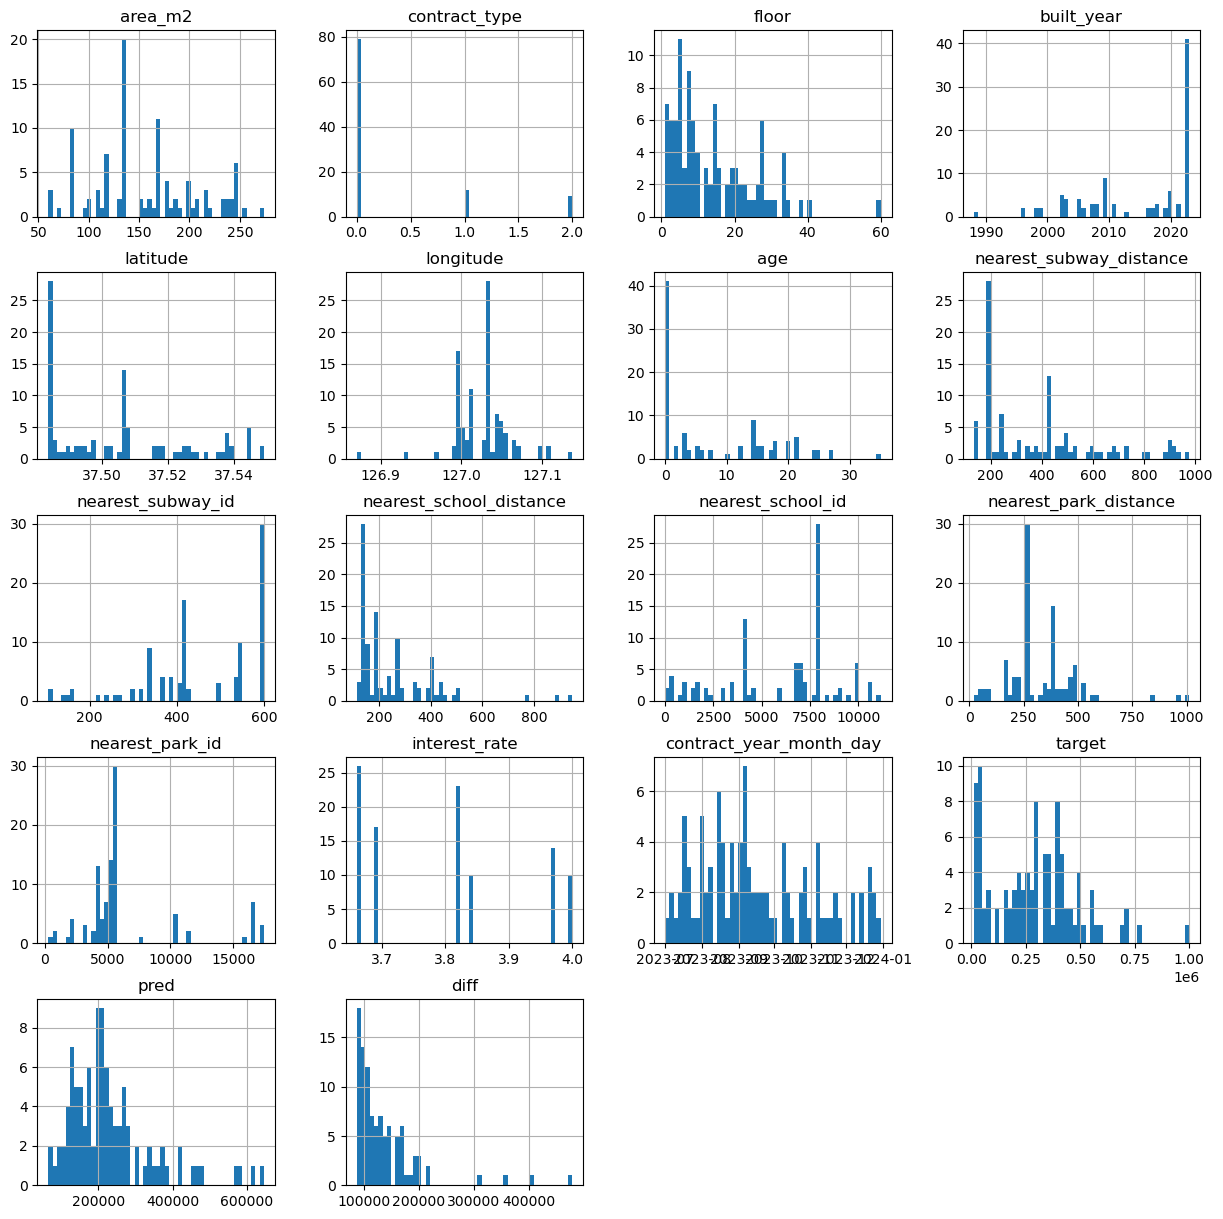

In [102]:
eda_df = pred_df.sort_values(by='diff', ascending=False).head(100)
eda_df.hist(bins=50, figsize=(15, 15))

In [164]:
pred_df = pd.DataFrame({'pred': deposit_holdout_pred, 'target': y_holdout})
pred_df["diff"] = pred_df["pred"] - pred_df["target"]
pred_df.describe()

,pred,target,diff
count,198636.000000,198636.000000,198636.000000
mean,16901.717699,40903.631089,-24001.913390
std,25324.092749,28571.795590,30937.150941
min,-201331.117277,955.000000,-629959.465151
25%,1896.996272,23000.000000,-39962.841158
50%,16454.088555,34458.000000,-19992.456430
75%,30695.842382,50000.000000,-3308.369406
max,454388.317350,1000000.000000,203687.407709


# Sample Submission 제출하기

In [104]:
# holdout 데이터셋도 학습에 사용
lgb_model.fit(X_holdout, deposit_per_area_holdout, init_model=lgb_model)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2863
[LightGBM] [Info] Number of data points in the train set: 198636, number of used features: 115


LGBMRegressor(random_state=42)

In [189]:
# 필요 없는 column 제거
test_df = test_data.drop(columns=["index"])

# contract_year_month, contract_day를 contract_year_month_day로 통합
test_df["contract_year_month_day"] = test_df["contract_year_month"] * 100 + test_df["contract_day"]
test_df.drop(columns=["contract_year_month", "contract_day"], inplace=True)

In [190]:
test_df_sorted = test_df.sort_values(by="contract_year_month_day")
train_df_sorted = train_df.sort_values(by="contract_year_month_day")

In [191]:
test_df = pd.merge_asof(
    test_df_sorted, train_df_sorted[["contract_year_month_day", "latitude", "longitude", "deposit_per_area"]],
    on='contract_year_month_day',  # 날짜를 기준으로 병합
    by=['latitude', 'longitude'],  # lat과 long이 같은 그룹에서
    direction='backward',  # test의 date보다 이전인 train의 가장 가까운 date를 선택
)
test_df.fillna(-999, inplace=True)

In [192]:
# cluster & one-hot encoding
test_df['cluster_100'] = kmeans.predict(test_df[['latitude', 'longitude']])
test_df = pd.get_dummies(test_df, columns=["cluster_100"])
# contract_type을 one-hot encoding
test_df = pd.get_dummies(test_df, columns=["contract_type"])

# one-hot encoding시 값이 없으면 column이 생기지 않으므로,
# train 데이터셋과 test 데이터셋의 column을 맞춰줌
test_df = test_df.reindex(columns=X_train.columns, fill_value=0)
# train_df의 column의 dtype과 test_df의 column의 dtype이 다른 경우가 있음
# train_df의 column의 dtype을 기준으로 test_df의 column의 dtype을 변경
for column in test_df.columns:
    if test_df[column].dtype != X_train[column].dtype:
        print(column)
        test_df[column] = test_df[column].astype(X_train[column].dtype)
test_df.shape

prev_deposit_per_area


(150172, 118)

In [193]:
lgb_test_pred = lgb_model.predict(test_df)

# 음수 예측값을 mean값으로 변경
# lgb_test_pred = np.where(lgb_test_pred < 0, lgb_test_pred.mean(), lgb_test_pred)
deposit_test_pred = lgb_test_pred * test_df['area_m2']
sample_submission['deposit'] = deposit_test_pred

In [144]:
index = datetime.datetime.now().strftime('%Y%m%d_%H%M')
sample_submission.to_csv(f'../../output/output_{index}_MAE_{lgb_holdout_mae:.2f}.csv', index=False, encoding='utf-8-sig')

# 기타: submission 분포 확인하기

In [194]:
sample_submission.describe()

,index,deposit
count,150172.00000,150172.000000
mean,75085.50000,15580.683329
std,43351.06665,25223.002520
min,0.00000,-116185.289762
25%,37542.75000,506.251190
50%,75085.50000,14869.930405
75%,112628.25000,29647.136837
max,150171.00000,369326.498006
